## In-Class Demonstration and Visualization

In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
# You can change the default figure size to be a bit larger if you want,
# uncomment the next line for that:
plt.rc('figure', figsize=(10, 6))

The function `plot_taylor_approximations` included here was written by Fernando Perez and was part of work on the original `IPython` project.  Although attribution seems to have been lost over time, we gratefully acknowledge FP and thank him for this code!

In [3]:
def plot_taylor_approximations(func, x0=None, orders=(2, 4), xrange=(0,1), yrange=None, npts=200):
    """Plot the Taylor series approximations to a function at various orders.

    Parameters
    ----------
    func : a sympy function
    x0 : float
      Origin of the Taylor series expansion.  If not given, x0=xrange[0].
    orders : list
      List of integers with the orders of Taylor series to show.  Default is (2, 4).
    xrange : 2-tuple or array.
      Either an (xmin, xmax) tuple indicating the x range for the plot (default is (0, 1)),
      or the actual array of values to use.
    yrange : 2-tuple
      (ymin, ymax) tuple indicating the y range for the plot.  If not given,
      the full range of values will be automatically used. 
    npts : int
      Number of points to sample the x range with.  Default is 200.
    """
    if not callable(func):
        raise ValueError('func must be callable')
    if isinstance(xrange, (list, tuple)):
        x = np.linspace(float(xrange[0]), float(xrange[1]), npts)
    else:
        x = xrange
    if x0 is None: x0 = x[0]
    xs = sp.Symbol('x')
    # Make a numpy-callable form of the original function for plotting
    fx = func(xs)
    f = sp.lambdify(xs, fx, modules=['numpy'])
    # We could use latex(fx) instead of str(), but matploblib gets confused
    # with some of the (valid) latex constructs sympy emits.  So we play it safe.
    plt.plot(x, f(x), label=str(fx), lw=2)
    # Build the Taylor approximations, plotting as we go
    apps = {}
    for order in orders:
        app = fx.series(xs, x0, n=order).removeO()
        apps[order] = app
        # Must be careful here: if the approximation is a constant, we can't
        # blindly use lambdify as it won't do the right thing.  In that case, 
        # evaluate the number as a float and fill the y array with that value.
        if isinstance(app, sp.numbers.Number):
            y = np.zeros_like(x)
            y.fill(app.evalf())
        else:
            fa = sp.lambdify(xs, app, modules=['numpy'])
            y = fa(x)
        tex = sp.latex(app).replace('$', '')
        plt.plot(x, y, label=r'$n=%s:\, %s$' % (order, tex) )
        
    # Plot refinements
    if yrange is not None:
        plt.ylim(*yrange)
    plt.grid()
    plt.legend(loc='best').get_frame().set_alpha(0.8)
    
# For an expression made from elementary functions, we must first make it into
# a callable function, the simplest way is to use the Python lambda construct.
# plot_taylor_approximations(lambda x: 1/sp.cos(x), 0, [2,4,6,8], (0, 2*sp.pi), (-5,5))

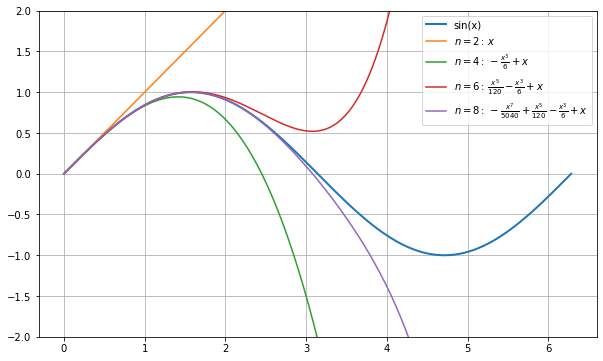

In [4]:
plot_taylor_approximations(sp.sin, 0, [2, 4, 6, 8], (0, 2*sp.pi), (-2,2))

# Lecture 10:  Taylor's Series and Discrete Calculus

## Background

It is common in physics and engineering to represent transcendental functions and other nonlinear expressions using a few terms from a Taylor series.  This series provides a fast and efficient way to compute quantities such as $\mathrm{sin}(x)$ or $e^x$ to a prescribed error.  Learning how to calculate the series representation of these functions will provide practical experience with the Taylor series and help the student understand the results of Python methods designed to accelerate and simplify computations.  The series can be written generally as:

$$f(x) = f{\left (0 \right )} + x \left. \frac{d}{d x} f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{x^{2}}{2} \left. \frac{d^{2}}{d x^{2}}  f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{x^{3}}{6} \left. \frac{d^{3}}{d x^{3}}  f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{x^{4}}{24} \left. \frac{d^{4}}{d x^{4}}  f{\left (x \right )} \right|_{\substack{ x=0 }} + \frac{x^{5}}{120} \left. \frac{d^{5}}{d x^{5}}  f{\left (x \right )} \right|_{\substack{ x=0 }} + \mathcal{O}\left(x^{6}\right)$$

Of equal importance the Taylor series permits discrete representation of derivatives and is a common way to perform numerical integration of partial and ordinary differential equations.  Expansion of a general function $f(x)$ about a point, coupled with algebraic manipulation, will produce expressions that can be used to approximate derivative quantities.  Although any order of derivative can be computed, this lesson will focus on first and second derivatives that will be encountered in the diffusion equation.


## What Skills Will I Learn?

You will practice the following skills:

* Defining and determining the limits of infinite sequences, series and power series.
* Define the Taylor series and write the general form about any point and to any order.
* Derive the central and forward difference formulae for numerical derivatives using the Taylor's series.

## What Steps Should I Take?

1.  Learn to use Sympy to define and find the limits of sequences are series.
1.  Learn how to approximate transcendental functions about center points of your choosing.
1.  Differentiate an explicit series representation of a function to see that the coefficients of such a series can be determined algebraically.
1.  Use Sympy to compute a power series symbolically
1.  Derive the finite difference expressions for the first and second derivatives.
1.  Read the relevant pages from Hornbeck's text on numerical methods.
1.  Generate a list of values that approximate the function $f(x)=x^8$ on the domain $\{x | 0 \leq x \leq 1\}$.  Using these values, numerically compute the derivative at your selected grid points and compare it to the analytical solution.  Using this technique, examine how the observed error changes as the number of grid points is varied.  Visualize and explain the results.
1.  Prepare a new notebook (not just modifications to this one) that describes your approach.

Optional challenge:  A _list_ is one of the fundamental data structures within Python.  Numpy (a Python library) and other parts of Python libraries use _vectorized_ computations.  From Wikipedia, vectorization is "a style of computer programming where operations are applied to whole arrays instead of individual elements."  

With this in mind, we certainly _can_ iterate over our list of points and apply the function that you will soon write in an element by element fashion, however, it is a more common practice in Python and other modern languages to write vectorized code.  If this is your first exposure to vectorized computation, I recommend two initial strategies:  write out your algorithms and use "classic" flow control and iteration to compute the results.  From that point you will more easily see the strategy you should use to write vectorized code.  

Using the discrete forms of the first and second derivatives (based on central differences) can you devise a vectorized operation that computes the derivative without looping in Python?

## A Sucessful Jupyter Notebook Will

* Present a description of the essential elements of Taylor's series and how to compute numerical derivatives;
* Identify the audience for which the work is intended;
* Run the code necessary to compute and visualize the error associated with the second order approximation and the changes in grid point spacing;
* Provide a narrative and equations to explain why your approach is relevant to solving the problem;
* Provide references and citations to any others' work you use to complete the assignment;
* Be checked into your GitHub repository by the due date (one week from assignment).

A high quality communication provides an organized, logically progressing, blend of narrative, equations, and code that teaches the reader a particular topic or idea.  You will be assessed on:
* The functionality of the code (i.e. it should perform the task assigned).
* The narrative you present.  I should be able to read and learn from it.  Choose your audience wisely.
* The supporting equations and figures you choose to include.

If your notebook is just computer code your assignment will be marked incomplete.

## Reading and Reference

* Essential Mathematical Methods for Physicists, H. Weber and G. Arfken, Academic Press, 2003
* Advanced engineering Mathematics, E. Kreyszig, John wiley and Sons, 2010
* Numerical Recipes, W. Press, Cambridge University Press, 1986
* Numerical Methods, R. Hornbeck, Quantum Publishers, 1975

### Infinite Sequences
----

Ideas relating to sequences, series, and power series are used in the formulation of integral calculus and in the construction of polynomial representations of functions.  The limit of functions will also be investigated as boundary conditions for differential equations.  For this reason understanding concepts related to sequences and series are important to review.   

A sequence is an ordered list of numbers.  A list such as the following represents a sequence:

$$a_1, a_2, a_3, a_4, \dots, a_n, \dots $$

The sequence maps one value $a_n$ for every integer $n$.  It is typical to provide a formula for construction of the nth term in the sequence.  While _ad-hoc_ strategies could be used to develop sequences using SymPy and lists in Python, SymPy has a sequence class that can be used.  A short demonstration is provided next:

In [5]:
import sympy as sp
x, y, z, t, a = sp.symbols('x y z t a')
k, m, n = sp.symbols('k m n', integer=True)
f, g, h = sp.symbols('f g h', cls=sp.Function)
sp.var('a1:6')
sp.init_printing()

It is important to read about `SymPy` symbols at this time.

We can generate a sequence using `SeqFormula`.

In [6]:
a1 = sp.SeqFormula(n**2, (n,0,5))
list(a1)

if we want the limit of the sequence at infinity:

$$[0, 1, 4, 9, \ldots ]$$

we can use `limit_seq`:

In [7]:
sp.limit_seq(a1.formula, n)

### DIY:  Determine if the following sequences are convergent or divergent.  If convergent, what is the limit?

$$
\begin{aligned}
a_n = & \frac{1}{n} \\
a_n = & 1 - (0.2)^n \\
a_n = & \frac{1}{2n+1}
\end{aligned}
$$


In [8]:
# Your code here.

### Infinite Series
----

A series is the sum of a sequence.  An infinite series will converge if the partial sums of the series has a finite limit.  For example, examine the partial sums of the series:

$$
\sum^{\infty}_{n=1} \frac{1}{2^n}
$$

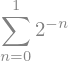

In [9]:
a2 = sp.Sum(1/2**n, (n,0,1))
a2

In [10]:
a2.doit()

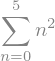

In [11]:
a4 = sp.Sum(n**2, (n,0,5))
a4

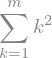

In [12]:
a5 = sp.Sum(k**2, (k, 1, m))
a5

In [13]:
a4.doit()

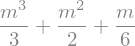

In [14]:
a5.doit()

A power series is of the form:

$$
\sum_{n=0}^{\infty} M_{n} x^{n} = M_0 + M_1 x + M_2 x^2 + \cdots
$$


In [15]:
M = sp.IndexedBase('M')

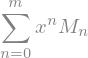

In [16]:
sp.Sum(M[n]*x**n, (n,0,m))

We can define the series about the point $a$ as follows:

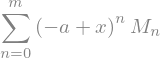

In [17]:
sp.Sum(M[n]*(x-a)**n, (n,0,m))

SymPy has a function that can take SymPy expressions and represent them as power series:

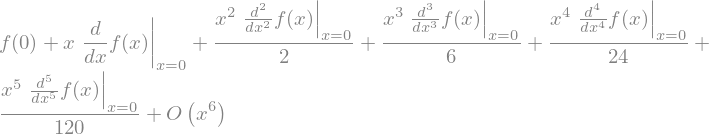

In [18]:
sp.series(f(x), x, x0=0)

### DIY:  Use SymPy to determine series approximations to $e^x$, $sin(x)$, and $cos(x)$ about the point $x=0$.

In [19]:
# Your code here.

### Taylor's Series
----

Below we present a derivation of Taylor's series and small algebraic argument for series representations of functions.  In contrast to the ability to use `sympy` functions without any deeper understanding, these presentations are intended to give you insight into the origin of the series representation and the factors present within each term.  While the algebraic presentation isn't a general case, the essential elements of a general polynomial representation are visible.

The function $f(x)$ can be expanded into an infinite series or a finite series plus an error term.  Assume that the function has a continuous nth derivative over the interval $a \le x \le b$.  Integrate the nth derivative n times:

$$\int_a^x f^n(x) dx = f^{(n-1)}(x) - f^{(n-1)}(a)$$

The power on the function $f$ in the equation above indicates the order of the derivative.  Do this n times and then solve for f(x) to recover Taylor's series.  One of the key features in this derivation is that the integral is definite.  This derivation is outlined on [Wolfram’s Mathworld](http://mathworld.wolfram.com/TaylorSeries.html).

As a second exercise, assume that we wish to expand sin(x) about x=0.  First, assume that the series exists and can be written as a power series with unknown coefficients.  As a first step, differentiate the series and the function we are expanding.  Next, let the value of x go to the value of the expansion point and it will be possible to evaluate the coefficients in turn:

$$
\sin x = A+Bx+Cx^2+Dx^3+Ex^4
$$

We can choose an expansion point (e.g. $x = 0$) and differentiate to get a set of simultaneous equations permitting determination of the coefficients.  The computer algebra system can help us with this activity:

In [20]:
import sympy as sp
sp.init_printing()

In [21]:
x, A, B, C, D, E = sp.symbols('x, A, B, C, D, E')

To help us get our work done we can use `sympy`'s `diff` function.  Testing this function with a known result, we can write:

In [22]:
sp.diff(sp.sin(x),x)

A list comprehension is used to organize the results.  In each iteration the exact function and the power series are differentiated and stored as an element of a list.  The list can be inspected and a set of simultaneous equations can be written down and solved to determine the values of the coefficients.  Casting the list as a `sympy` `Matrix` object clarifies the correspondance between entries in the list.

In [23]:
orderOfDifferentiation = 1
powerSeries = A+B*x+C*x**2+D*x**3+E*x**4
# Differentiate, element by element, the list [sp.sin(x),powerSeries]
[sp.diff(a,x,orderOfDifferentiation) for a in [sp.sin(x),powerSeries]]

A list comprehension can be used to organize and extend the results further.  We can wrap the list above into another list that changes the order of differentiation each iteration.

In [24]:
maximumOrder = 5
funcAndSeries = [[sp.diff(a,x,order) for a in [sp.sin(x),powerSeries]] for order in range(maximumOrder)]
funcAndSeries

Casting the results as a `sympy` `Matrix` object the list is more easily viewed in the Jupyter notebook:

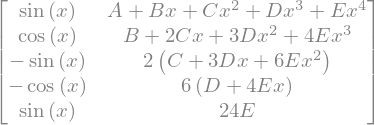

In [25]:
sp.Matrix(funcAndSeries)

### DIY:  Determine the coefficients in the above power series.
----

You don't necessarily need to write code to complete this DIY problem.


In [26]:
# Your code here if you feel you need it.

`Your markdown here.`

### Computing a Taylor's Series Symbolically
---

Using `sympy` the Taylor's series can be computed symbolically.

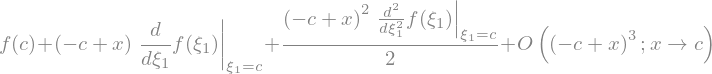

In [27]:
from sympy import init_printing, symbols, Function
init_printing()

x, c = symbols("x,c")
f = Function("f")

f(x).series(x, x0=c, n=3)

One of the major uses of Taylor's series in computation is for the evaluation of derivatives.  Take note of the fact that the derivatives of a function appear in the evaluation of the series.

### Computing Derivatives of Discrete Data
---

It may be straightforward to compute the derivative of some functions.  For example:

$$f(x) = x^2$$
$$f'(x) = 2x$$

In numerical computing situations there is no analytical solution to the problem being solved and therefore no function to integrate or differentiate.  The approximate solution is available as a list of discrete points in the domain of the problem's independent variables (e.g. space, time).  The values could be represented as a list of numbers:

$$\{f(x_0), f(x_1), f(x_2), ...\}$$

The neighboring points $f(x_0)$ and $f(x_1)$ are seperated by a distance $\Delta x = x_1 - x_0$ in the independent variable.  Although this will not be apparent from the values, it is implicit in the structure of the data.  Taylor's series can be used to compute approximate derivatives of the unknown function directly from the list of points in this situation.  We are going to compute a series expansion for an unknown function $f(x)$ in the vicinity of the point $c$ and then examine the relationship between that function and it's derivative quantities at a point $c\pm h$.  The goal of the activity is to see if we can find expressions for the derivatives using the data point of interest ($c$) and its neighbors ($c \pm h$).  We are going to use the idea of _forward_ and _backward_ differences.

1. Forward differences are computed by expanding an unknown function in a Taylor series about a point “x=c” and then letting x go to c+h.
1. Then, for backward differences, let x go to c-h.

### Symbolically Computing Forward and Backward Differences
---

In the figure below we indicate the following:

* the unknown function $f(x)$ as a dashed line
* the point about which the unknown function is expanded at $x=c$
* the distance between successive points is shown as $h$
* the approximate values of the function given at the filled squares

![Approximation](./images/derivative.png)

Imagine that we take the above series expansion and use it to compute the value of the function near the point $c$.  Let us evaluate this series by adding and subtracting to the independent varable the quantity $h$.  To accomplish this we write down the series expansion for our function about the point $c$, then we let the independent variable $x \rightarrow c+h$ and $c-h$.

In [28]:
x, h, c = sp.symbols("x,h,c")
f = sp.Function("f")

# the .subs() method replaces occurences of 'x' with something else
taylorExpansionPlus = f(x).series(x, x0=c, n=3).removeO().subs(x,c+h)
taylorExpansionMinus = f(x).series(x, x0=c, n=3).removeO().subs(x,c-h)

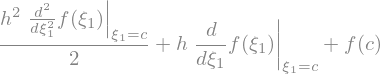

In [29]:
taylorExpansionPlus

Meaning that:

$$
f(c+h) = \frac{h^{2}}{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + f{\left (c \right )}
$$

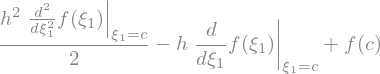

In [30]:
taylorExpansionMinus

Meaning that:

$$
f(c-h) = \frac{h^{2}}{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} - h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + f{\left (c \right )}
$$

### Solving for First and Second Derivatives
----

Inspection of the results shows that the signs on the terms containing the first derivative are different between the two expressions.  We can use this to our advantage in solving for the derivative terms explicitly.  Note that each grouped expression is equal to zero as is the default in `sympy`.

_Find the first derivative in this expression:_

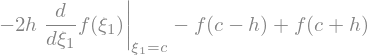

In [31]:
(taylorExpansionMinus-f(c-h))-(taylorExpansionPlus-f(c+h))

Remember that `sympy` expressions are zero by default.  So this is true:

$$
- 2 h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} - f{\left (c - h \right )} + f{\left (c + h \right )} = 0
$$

_Find the second derivative in this expression:_

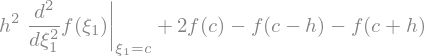

In [32]:
(taylorExpansionMinus-f(c-h))+(taylorExpansionPlus-f(c+h))

Similarly:

$$
h^{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + 2 f{\left (c \right )} - f{\left (c - h \right )} - f{\left (c + h \right )} = 0
$$

Solve each of the equations above for the derivative quantites and you will have recovered the formula for discrete derivatives.

Use these expressions to complete your assignment as outlined above.